# Рекомендация тарифов

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Построим модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверить *accuracy* на тестовой выборке.

 ## Открываем и изучаем файл

### Подключение необходимых библиотек

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import joblib

### Открытие файла 

In [2]:
# Сохраним датасет в переменную df и выведем ее
df = pd.read_csv('/datasets/users_behavior.csv')
display(df)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
...,...,...,...,...,...
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0


### Описание данных

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
сalls — количество звонков,
minutes — суммарная длительность звонков в минутах,
messages — количество sms-сообщений,
mb_used — израсходованный интернет-трафик в Мб,
is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

In [3]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [5]:
df.isna().mean()

calls       0.0
minutes     0.0
messages    0.0
mb_used     0.0
is_ultra    0.0
dtype: float64

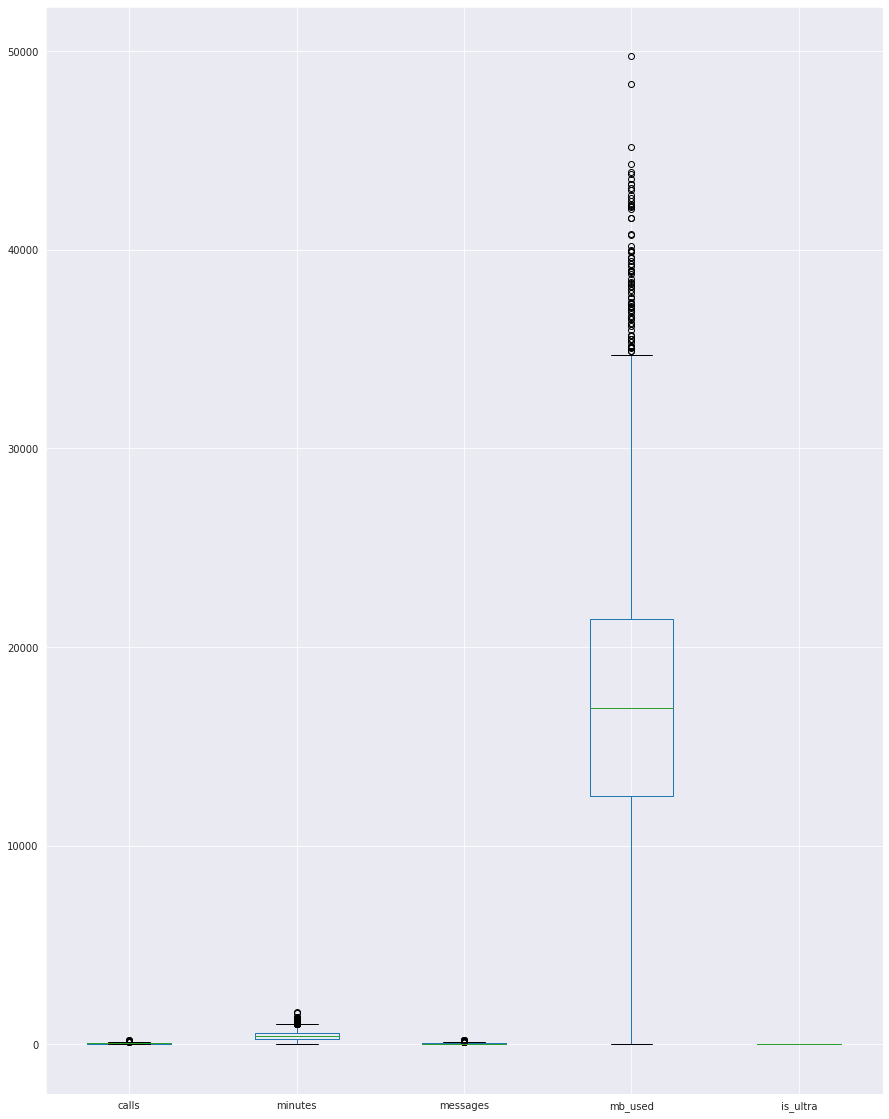

In [6]:
df[['calls', 'minutes', 'messages', 'mb_used', 'is_ultra']].boxplot(figsize=(15,20));

In [7]:
n = df.loc[df['mb_used'] >33000]['mb_used'].count()
print((n/len(df['mb_used'])*100).round(2), "%" ) 
print("количество позиций, у которых траффик превышает 33000 mb")

3.3 %
количество позиций, у которых траффик превышает 33000 mb


In [8]:
print(df.corr())

             calls   minutes  messages   mb_used  is_ultra
calls     1.000000  0.982083  0.177385  0.286442  0.207122
minutes   0.982083  1.000000  0.173110  0.280967  0.206955
messages  0.177385  0.173110  1.000000  0.195721  0.203830
mb_used   0.286442  0.280967  0.195721  1.000000  0.198568
is_ultra  0.207122  0.206955  0.203830  0.198568  1.000000


Матрица корреляций показывает большую зависимость между calls и minutes. Посмотрим на графиках.

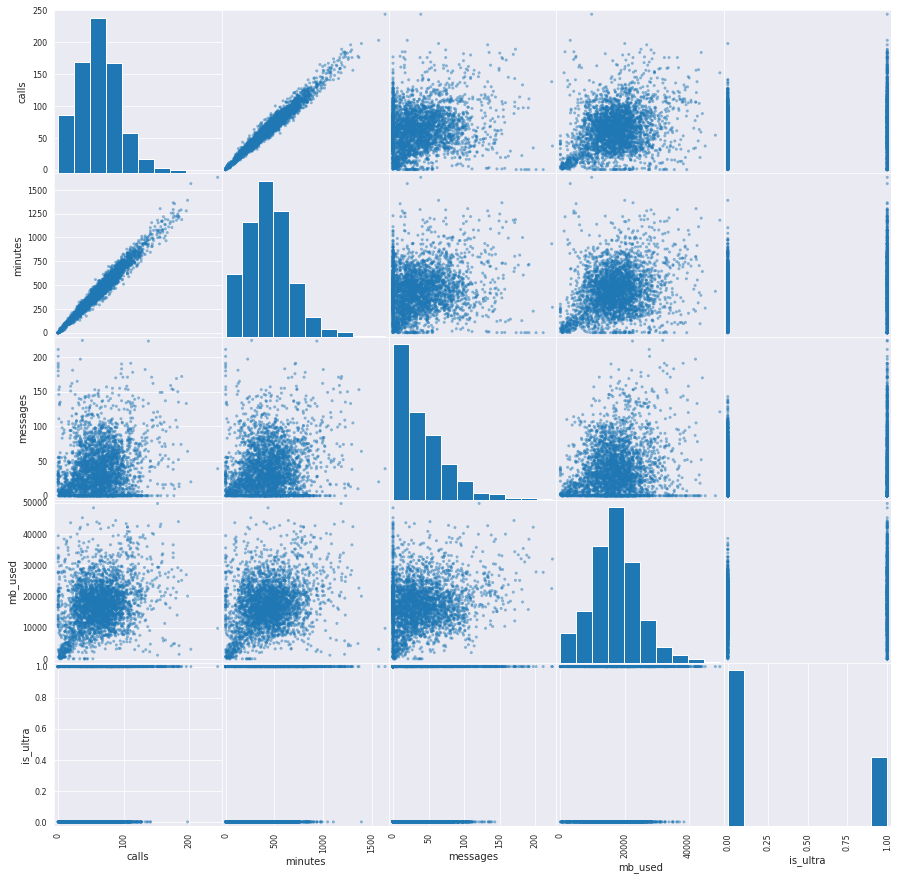

In [9]:
pd.plotting.scatter_matrix(df, figsize=(15, 15))
plt.show()

Графики показывают прямую линейную зависимость между звонками и минутами. 

Создадим отдельный датасет без одного из признаков (например, без звонков). Посмотрим, как это повлияет на качество моделей.</div> 

In [10]:
df_min = df.drop(['calls'],axis = 1)
df_min

,minutes,messages,mb_used,is_ultra
0,311.90,83.0,19915.42,0
1,516.75,56.0,22696.96,0
2,467.66,86.0,21060.45,0
3,745.53,81.0,8437.39,1
4,418.74,1.0,14502.75,0
...,...,...,...,...
3209,910.98,20.0,35124.90,1
3210,190.36,0.0,3275.61,0
3211,634.44,70.0,13974.06,0
3212,462.32,90.0,31239.78,0


## Разбиваем данные на выборки

In [11]:
df = df_min
size = 0.20 

Используя метод train_test_split, разобъем исходный датасет на 3 выборки, train, valid и test, в соотношении 60/20/20 % от общих данных, соответственно.

In [12]:
#С помощью train_test_split Разделим датасет на следующие выборки 
df_train, df_valid = train_test_split(df, test_size=size, random_state=12345)
df_valid, df_test = train_test_split(df_valid,test_size = 0.5, random_state=12345)
print('Размер обучающей выборки:', df_train.shape[0],'объектов')
print('Размер валидационной выборки:', df_valid.shape[0],'объекта')
print('Размер тестовой выборки:',df_test.shape[0],'объекта')


Размер обучающей выборки: 2571 объектов
Размер валидационной выборки: 321 объекта
Размер тестовой выборки: 322 объекта


Выделяем признаки (features) и целевой признак(target) в каждой выборке.
Целевым признаком становятся значения столбца 'is_ultra', признаками - значения всех остальных столбцов.

In [13]:
#Присвоим переменным признаки и целевые признаки
features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']
#Валидационная выборка
valid_features = df_valid.drop(['is_ultra'], axis=1)
valid_target = df_valid['is_ultra']
#Обучающая выборка
train_features = df_train.drop(['is_ultra'], axis=1)
train_target = df_train['is_ultra']
#Тестовая выборка
test_features = df_test.drop(['is_ultra'], axis=1)
test_target = df_test['is_ultra']


В нашем портфеле необходимо решить задачу бинарной классификации - определить какой из двух тарифов {'smart' : 0, 'ultra' : 1} необходимо предложить клиентам на основании их текущего потребления услуг.
Определив требуемый вид моделей переходим к исследованиям.

## Исследуем модели

### Дерево решений (Decision Tree Classifier)

Depth: 1 Accuracy: 0.7414330218068536
Depth: 2 Accuracy: 0.7819314641744548
Depth: 3 Accuracy: 0.7881619937694704
Depth: 4 Accuracy: 0.794392523364486
Depth: 5 Accuracy: 0.778816199376947
Depth: 6 Accuracy: 0.7850467289719626
Depth: 7 Accuracy: 0.7819314641744548
Depth: 8 Accuracy: 0.778816199376947
Depth: 9 Accuracy: 0.7757009345794392

Лушие: Depth 4 Accuracy 0.794392523364486




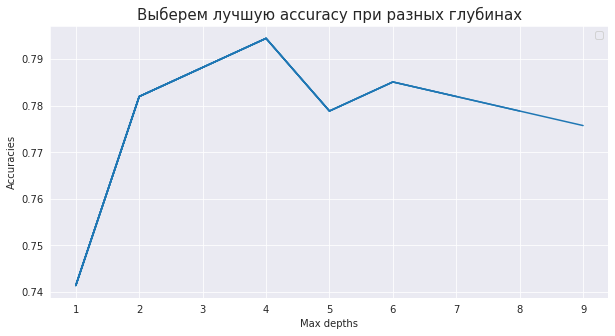

In [14]:
#Обучим модель Дерево Решений и проверим разные глубины

depths = []
DTC_accuracies = []
plt.figure(figsize=(10, 5))
DTC_best_accuracies=0
best_depth=-1
i=-1
for depth in range(1,10):
 i+=1    
 model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
 model.fit(train_features,train_target)
 predictions = model.predict(valid_features)
 score = accuracy_score(valid_target, predictions)
 depths.append(depth)
 DTC_accuracies.append(score)
 print('Depth:', depth, end='')
 print(' Accuracy:', score)
 if DTC_accuracies[i] > DTC_best_accuracies:
  DTC_best_accuracies = DTC_accuracies[i]
  best_depth=depth 
 sns.lineplot(data=pd.DataFrame(data=DTC_accuracies, index=depths),dashes=False)
 plt.legend('')
print()
print("Лушие: Depth", best_depth, "Accuracy", DTC_best_accuracies)    
print('\n')
plt.title("Выберем лучшую accuracy при разных глубинах", fontsize=15)
plt.ylabel("Accuracies")
plt.xlabel("Max depths")
plt.show()
print('\n\n')

### Случайный лес (Random Forest Classifier) 

Estimator: 10 Accuracy: 0.8006230529595015
Estimator: 15 Accuracy: 0.8006230529595015
Estimator: 20 Accuracy: 0.7975077881619937
Estimator: 25 Accuracy: 0.8006230529595015
Estimator: 30 Accuracy: 0.794392523364486
Estimator: 35 Accuracy: 0.7975077881619937
Estimator: 40 Accuracy: 0.8006230529595015
Estimator: 45 Accuracy: 0.8006230529595015
Estimator: 50 Accuracy: 0.794392523364486

Лушие: Estimator 10 Accuracy 0.8006230529595015




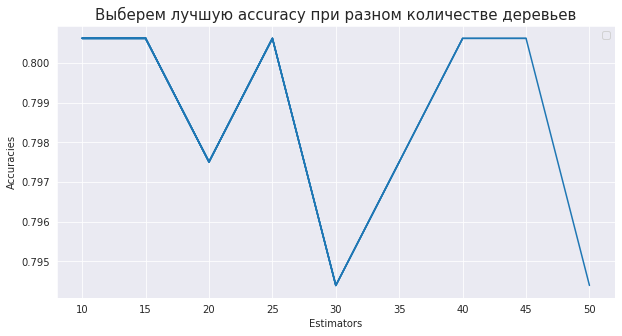

In [15]:
#Обучим модель случайный лес с разным количеством деревьев в лесу.

estimators = []
RFC_accuracies = []
best_accuracies=0
best_estim=-1
i=-1
plt.figure(figsize=(10, 5))
for estim in range(10,51,5):
 i+=1   
 model = RandomForestClassifier(random_state=12345, n_estimators=estim)
 model.fit(train_features, train_target)
 predictions = model.predict(valid_features)
 score = accuracy_score(valid_target, predictions)
 estimators.append(estim)
 RFC_accuracies.append(score)
 if RFC_accuracies[i] > best_accuracies:
  best_accuracies = RFC_accuracies[i]
  best_estim=estim 
 print('Estimator:', estim, end='')
 print(' Accuracy:', score)
 sns.lineplot(data=pd.DataFrame(data=RFC_accuracies, index=estimators),legend='brief')
 plt.legend('')
print()
print("Лушие: Estimator", best_estim, "Accuracy", best_accuracies)
print('\n')
plt.title("Выберем лучшую accuracy при разном количестве деревьев", fontsize=15)
plt.ylabel("Accuracies")
plt.xlabel("Estimators")
plt.show()
print('\n\n')


Лучший результат max_depth = 9, accuracy = 0.8068535825545171 

### Логистическая регрессия (Logistic Regression)

In [16]:
model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000) 
model.fit(train_features, train_target)

#valid_prediction = model_lr.predict(valid_features)

print('accuracy =', model.score(valid_features, valid_target))

accuracy = 0.7663551401869159


In [17]:
#Создадим таблицу с полученными accuracy
columns=['DecisionTreeClassifier','RandomForestClassifier','LogisticRegression']

data = pd.DataFrame(columns=columns)
data['DecisionTreeClassifier'] = DTC_accuracies
data['RandomForestClassifier'] = RFC_accuracies
data['LogisticRegression'] = model.score(valid_features, valid_target)
data

,DecisionTreeClassifier,RandomForestClassifier,LogisticRegression
0,0.741433,0.800623,0.766355
1,0.781931,0.800623,0.766355
2,0.788162,0.797508,0.766355
3,0.794393,0.800623,0.766355
4,0.778816,0.794393,0.766355
5,0.785047,0.797508,0.766355
6,0.781931,0.800623,0.766355
7,0.778816,0.800623,0.766355
8,0.775701,0.794393,0.766355


In [18]:
print("DecisionTreeClassifier Лушие: Depth", best_depth, "Accuracy", DTC_best_accuracies)
print("RandomForestClassifier Лушие: Estimator", best_estim, "Accuracy", best_accuracies)
print("LogisticRegression Accuracy =", model.score(valid_features, valid_target))


DecisionTreeClassifier Лушие: Depth 4 Accuracy 0.794392523364486
RandomForestClassifier Лушие: Estimator 10 Accuracy 0.8006230529595015
LogisticRegression Accuracy = 0.7663551401869159


При нашем выборе параметров лучший реультат показывает RandomForestClassifier Лушие: Estimator 10 Accuracy 0.8006230529595015

Худший результат показывает LogisticRegression: Accuracy = 0.7663551401869159

Построим график, чтобы наглядно увидеть, какая модель нас больше устраивает

<AxesSubplot:title={'center':'Совместим все модели на одном графике'}, ylabel='Accuracy'>

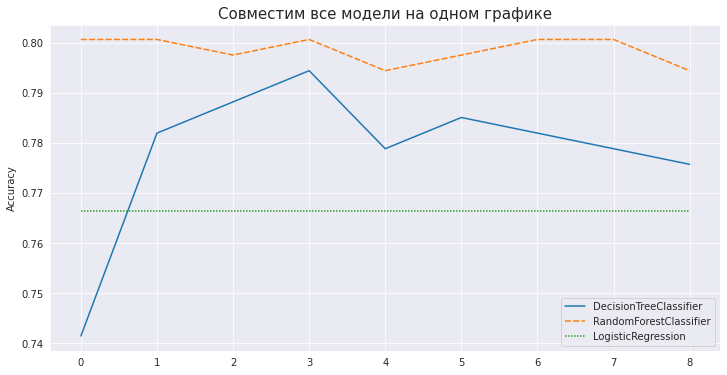

In [19]:
plt.figure(figsize=(12,6))
plt.title('Совместим все модели на одном графике', fontsize=15)
plt.xlabel('')
plt.ylabel('Accuracy')
sns.lineplot(data=data)

Вывод.

При нашем выборе параметров лучший реультат показывает 
RandomForestClassifier Лушие: Estimator 10 Accuracy 0.8006230529595015

Худший результат показывает
LogisticRegression: Accuracy = 0.7663551401869159

## Проверим модель на тестовой выборке

In [20]:
#Проверим модель: Случайный лес на тестовой выборке при 20 деревьях
model = RandomForestClassifier(random_state=12345, n_estimators=20)
model.fit(train_features,train_target)
predictions = model.predict(test_features)
score = accuracy_score(test_target, predictions)
print('Accuracy:', score)

Accuracy: 0.7919254658385093


## Проверим модели на адекватность

In [21]:

df['is_ultra'].value_counts(normalize=True)

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

In [22]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
model = RandomForestClassifier(random_state=12345, n_estimators=20)
model.fit(train_features,train_target)
features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']
answers = target
print(answers)
predictions = model.predict(features)
print(predictions)

mse = mean_squared_error(answers, predictions)
rmse = mse ** 0.5
mae = mean_absolute_error(answers, predictions)
print("mse", mse)
print("rmse", rmse)
print("mae", mae)
print()
print("Ошибок:", mae*len(answers), "из", len(answers), "-", (mae*100).round(2), "%" )



0       0
1       0
2       0
3       1
4       0
       ..
3209    1
3210    0
3211    0
3212    0
3213    1
Name: is_ultra, Length: 3214, dtype: int64
[0 0 0 ... 0 0 1]
mse 0.04822650902302427
rmse 0.21960534834794956
mae 0.04822650902302427

Ошибок: 155.0 из 3214 - 4.82 %


Таким образом, для модели RandomForestClassifier с Estimators=20 количество ошибок предсказаний 4.82 %, что говорит об адекватности данной модели.

# Вывод

Получены следующие результаты исследования по рассмотренным вариантам.

1. df = df, size=0.20 (разбивка 80-10-10)

DecisionTreeClassifier Лушие: Depth 6 Accuracy 0.7975077881619937
RandomForestClassifier Лушие: Estimator 20 Accuracy 0.8068535825545171
LogisticRegression Accuracy = 0.7663551401869159

При нашем выборе параметров лучший реультат показывает 
RandomForestClassifier: Estimator 20 Accuracy 0.8068535825545171

Худший: LogisticRegression Accuracy = 0.7663551401869159

Тестовая выборка: Accuracy = 0.7701863354037267
Ошибок: 160.0 из 3214 - 4.98 %

2. df = df, size=0.40 (разбивка 60-20-20)

DecisionTreeClassifier Лушие: Depth 3 Accuracy 0.7853810264385692
RandomForestClassifier Лушие: Estimator 50 Accuracy 0.7916018662519441
LogisticRegression Accuracy = 0.7107309486780715

При нашем выборе параметров лучший реультат показывает 
RandomForestClassifier Лушие: Estimator 50 Accuracy 0.7916018662519441

Худший: LogisticRegression Accuracy = 0.7107309486780715

Тестовая выборка: Accuracy = 0.7822706065318819
Ошибок: 298.0 из 3214 - 9.27 %

3. df = df_min, size=0.20 (разбивка 80-10-10)

DecisionTreeClassifier Лушие: Depth 4 Accuracy 0.794392523364486
RandomForestClassifier Лушие: Estimator 10 Accuracy 0.8006230529595015
LogisticRegression Accuracy = 0.7663551401869159

При нашем выборе параметров лучший реультат показывает 
RandomForestClassifier Лушие: Estimator 10 Accuracy 0.8006230529595015

Худший: LogisticRegression Accuracy = 0.7663551401869159

Тестовая выборка: Accuracy = 0.7919254658385093
Ошибок: 155.0 из 3214 - 4.82 %

4. df = df_min, size=0.40 (разбивка 60-20-20)

DecisionTreeClassifier Лушие: Depth 4 Accuracy 0.7884914463452566
RandomForestClassifier Лушие: Estimator 20 Accuracy 0.7822706065318819
LogisticRegression Accuracy = 0.7076205287713841

При нашем выборе параметров лучший реультат показывает 
DecisionTreeClassifier Лушие: Depth 4 Accuracy 0.7884914463452566

Худший: LogisticRegression Accuracy = 0.7076205287713841

Тестовая выборка: Accuracy = 0.7776049766718507
Ошибок: 302.0 из 3214 - 9.4 %


Таким образом, лучший результат показывает модель (df_min, size=0.20 (разбивка 80-10-10)
RandomForestClassifier Лушие: Estimator 10 Accuracy 0.8006230529595015

Худший: LogisticRegression Accuracy = 0.7663551401869159

Тестовая выборка: Accuracy = 0.7919254658385093
Ошибок: 155.0 из 3214 - 4.82 %

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x] Jupyter Notebook открыт
- [х] Весь код исполняется без ошибок
- [х] Ячейки с кодом расположены в порядке исполнения
- [х] Выполнено задание 1: данные загружены и изучены
- [х] Выполнено задание 2: данные разбиты на три выборки
- [х] Выполнено задание 3: проведено исследование моделей
    - [х] Рассмотрено больше одной модели
    - [х] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [х] Написаны выводы по результатам исследования
- [х] Выполнено задание 3: Проведено тестирование
- [х] Удалось достичь accuracy не меньше 0.75
